In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import string, re, glob, os
from langdetect import detect
nlp = spacy.load("en_core_web_sm")

MATH_LABEL = 0
PAINT_LABEL = 1
DATA_DIR = "./data_files/"

### Data loading

In [2]:
# Extract category from filename
cats = ["mathematician", "painter"]
chain = "|".join(cats)
regex = "(.*)_({})".format(chain)
r = re.compile(regex)
namecat = [ [f, r.match(f).group(2)]  for f in glob.glob1("./data_files", "*.txt")]

In [3]:
# Reorganize data into category folders
all_files = glob.glob(os.path.join(DATA_DIR, "*.txt"))
for filename in all_files:
    os.rename(filename, os.path.join(DATA_DIR, r.match(filename).group(2), os.path.basename(filename)))

In [4]:
# Load data from folders into a df, each row is an article
def load_data():
    data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")
    df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
    return df

df = load_data()

In [5]:
def remove_highlights(row):
    reg = re.compile('(==(.*?)==)')
    row = re.sub(reg, ' ', row)
    return row

# remove spaces, breaklines, tabs
def pre_norm(row):
    return re.sub(r"[\n\t\s]+", " ", row)

In [6]:
df1 = df
df1["text"] = df1["text"].apply(remove_highlights)
df1["text"] = df1["text"].apply(pre_norm)

In [7]:
df1["nlp"] = df1["text"].apply(nlp)

### Tokenization (sentences & tokens)

In [8]:
def tokenize(row):
    tokens = []
    for sent in row.sents:
        sentence = []
        for token in sent:
            sentence.append(token)
        tokens.append(sentence)
    return tokens

In [9]:
df1["sents"] = df1["nlp"].apply(tokenize)

In [10]:
print("Number of sentences: ", sum(df1["sents"].apply(lambda x : len(x))))

Number of sentences:  29159


### Normalisation

In [11]:
def is_latin(word):
    return all(ord(c) < 128 for c in word)

def normalize(row, rm_stops=True, eng_only=True):
    """ Removes punctuation, stopwords if rm_stop is true, and non latin words"""
    trs = str.maketrans('', '', string.punctuation)
    normalized_row = []
    for sentence in row:
        norm_sent = []
        for t in sentence:
            if (rm_stops and t.is_stop) or (eng_only and not is_latin(t.text)):
                continue
            not_punct = t.text.translate(trs).lower()
            if not_punct:
                norm_sent.append(not_punct)
        if len(norm_sent) != 0:
            normalized_row.append(norm_sent)
            
    return normalized_row

In [12]:
df1["norm"] = df1["sents"].apply(normalize)
df1["norm_with_stops"] = df1["sents"].apply(normalize, rm_stops=False)

In [13]:
df1.head(5)

,text,label,nlp,sents,norm,norm_with_stops
0,"Ray Paul Authement Sr. (November 19, 1928 – Ap...",0,"(Ray, Paul, Authement, Sr, ., (, November, 19,...","[[Ray, Paul, Authement, Sr, .], [(, November, ...","[[ray, paul, authement, sr], [november, 19, 19...","[[ray, paul, authement, sr], [november, 19, 19..."
1,Hans Asper (c. 1499 – 21 March 1571) was a Swi...,1,"(Hans, Asper, (, c., 1499, –, 21, March, 1571,...","[[Hans, Asper, (, c., 1499, –, 21, March, 1571...","[[hans, asper, c, 1499, 21, march, 1571, swiss...","[[hans, asper, c, 1499, 21, march, 1571, was, ..."
2,Nachman Aronszajn (26 July 1907 – 5 February 1...,0,"(Nachman, Aronszajn, (, 26, July, 1907, –, 5, ...","[[Nachman, Aronszajn, (, 26, July, 1907, –, 5,...","[[nachman, aronszajn, 26, july, 1907, 5, febru...","[[nachman, aronszajn, 26, july, 1907, 5, febru..."
3,Kazimierz Abramowicz (1889–1936) was a Polish ...,0,"(Kazimierz, Abramowicz, (, 1889–1936, ), was, ...","[[Kazimierz, Abramowicz, (, 1889–1936, ), was,...","[[kazimierz, abramowicz, polish, mathematician...","[[kazimierz, abramowicz, was, a, polish, mathe..."
4,"Louis Auslander (July 12, 1928 – February 25, ...",0,"(Louis, Auslander, (, July, 12, ,, 1928, –, Fe...","[[Louis, Auslander, (, July, 12, ,, 1928, –, F...","[[louis, auslander, july, 12, 1928, february, ...","[[louis, auslander, july, 12, 1928, february, ..."


We transform all lists to strings and save the dataframe as a csv, which will be our input of 
the classification step

In [14]:
df1["norm_text"] = df1["norm"].apply(lambda x: " ".join(sum(x, [])))

In [15]:
df1["norm_stops_text"] = df1["norm_with_stops"].apply(lambda x: " ".join(sum(x, [])))

In [16]:
pred_data = df1[["norm_text", "text", "norm_stops_text", "label"]]

In [17]:
pred_data.to_csv("clean_data.csv")

### Sentences

#### Average sentence lengths

<AxesSubplot:title={'center':'avg_sent_len'}, xlabel='label'>

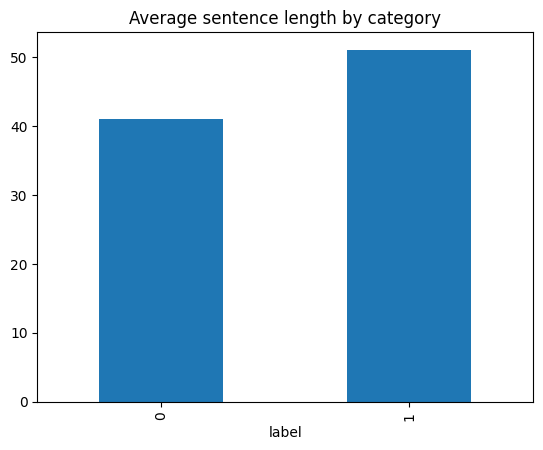

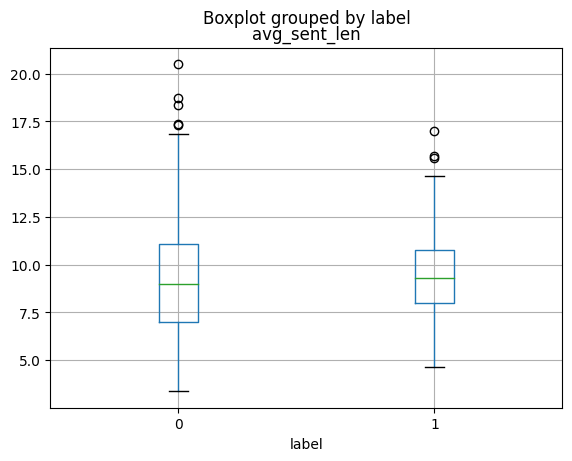

In [24]:
def avg_sentence_length(row):
    return sum(len(sublist) for sublist in row["norm"]) / len(row["norm"])

avg_sent = df1.groupby("label").apply(avg_sentence_length)
avg_sent.plot(kind='bar', title="Average sentence length by category")

df1["avg_sent_len"] = df1.apply(avg_sentence_length, axis=1)
df1.boxplot(by="label", column="avg_sent_len")

#### Min-Max sentence lengths

In [25]:
def min_sentence_length(row):
    return np.min([len(sublist) for sublist in row["norm"]])

def max_sentence_length(row):
    return np.max([len(sublist) for sublist in row["norm"]])

df1["min_sent_len"] = df1.apply(min_sentence_length, axis=1)
df1["max_sent_len"] = df1.apply(max_sentence_length, axis=1)

In [26]:
print("Minimum sentence length across all categories", df1["min_sent_len"].min())
print("Minimum sentence length per category", df1.groupby("label")["min_sent_len"].min())

print("Maximum sentence length across all catageories", df1["max_sent_len"].max())
print("Maximum sentence length per category", df1.groupby("label")["max_sent_len"].max())

Minimum sentence length across all categories 1
Minimum sentence length per category label
0    1
1    1
Name: min_sent_len, dtype: int64
Maximum sentence length across all catageories 131
Maximum sentence length per category label
0    131
1     87
Name: max_sent_len, dtype: int64


### Token occurences

In [27]:
# word freq by sentences for normalised data without stop words
df1["counter"] = df1["norm"].apply(lambda x: [Counter(sublist) for sublist in x])

In [28]:
# word freq by sentences for normalised data with stop words
df1["counter_w_stops"] = df1["norm_with_stops"].apply(lambda x: [Counter(sublist) for sublist in x])

In [29]:
# unroll each sentence into a row
df_count = df1[["counter", "label"]].explode("counter")

In [30]:
# Set index based on article, assigning a number to each sentence 
df_count['sent_nb'] = df_count.groupby(['label']).cumcount()+1

In [31]:
df_count

,counter,label,sent_nb
0,"{'guido': 1, 'ascoli': 1, '12': 1, 'december':...",0,1
0,"{'ascoli': 1, 'g': 2, 'burgatti': 1, 'p': 1, '...",0,2
0,"{'sansoni': 1, 'editore': 1, 'pp': 1}",0,3
0,"{'iv': 1, '186': 1}",0,4
0,"{'jfm': 1, '62054704': 1, 'available': 1, 'edi...",0,5
...,...,...,...
645,"{'evening': 1, 'sun': 1, '1878': 1, 'flowers':...",1,9492
645,"{'shower': 1, '1886': 1}",1,9493
645,"{'evening': 1, 'reflection': 1, '1887': 1, 're...",1,9494
645,{'1890': 1},1,9495


#### Min/max/avg number of token occurrences per sentence per category.

In [32]:
df_count["avg_tok_occ"] = df_count["counter"].apply(lambda x: np.mean(list(x.values())))
df_count["min_tok_occ"] = df_count["counter"].apply(lambda x: np.min(list(x.values())))
df_count["max_tok_occ"] = df_count["counter"].apply(lambda x: np.max(list(x.values())))

In [38]:
df_count.head(10)

,counter,label,sent_nb,avg_tok_occ,min_tok_occ,max_tok_occ
0,"{'guido': 1, 'ascoli': 1, '12': 1, 'december':...",0,1,1.000000,1,1
0,"{'ascoli': 1, 'g': 2, 'burgatti': 1, 'p': 1, '...",0,2,1.058824,1,2
0,"{'sansoni': 1, 'editore': 1, 'pp': 1}",0,3,1.000000,1,1
0,"{'iv': 1, '186': 1}",0,4,1.000000,1,1
0,"{'jfm': 1, '62054704': 1, 'available': 1, 'edi...",0,5,1.000000,1,1
0,"{'book': 1, 'collecting': 1, 'winning': 1, 'pa...",0,6,1.000000,1,1
0,"{'english': 1, 'translation': 1, 'title': 1, '...",0,7,1.000000,1,1
0,"{'oconnor': 1, 'john': 1, 'j': 1, 'robertson':...",0,8,1.111111,1,2
0,"{'guido': 1, 'ascoli': 1, 'bollettino': 1, 'de...",0,9,1.090909,1,2
0,"{'mr': 1, '0088442': 1, 'zbl': 1, '007700806':...",0,10,1.000000,1,1


In [56]:
df_count = df_count.reset_index()

In [ ]:
maximum_occ = df_count['max_tok_occ'].max()
d = dict(df_count.loc[df_count['max_tok_occ'].idxmax()]["counter"])
list(d.keys())[list(d.values()).index(maximum_occ)]

In [55]:
df_count

,counter,label,sent_nb,avg_tok_occ,min_tok_occ,max_tok_occ
0,"{'guido': 1, 'ascoli': 1, '12': 1, 'december':...",0,1,1.000000,1,1
0,"{'ascoli': 1, 'g': 2, 'burgatti': 1, 'p': 1, '...",0,2,1.058824,1,2
0,"{'sansoni': 1, 'editore': 1, 'pp': 1}",0,3,1.000000,1,1
0,"{'iv': 1, '186': 1}",0,4,1.000000,1,1
0,"{'jfm': 1, '62054704': 1, 'available': 1, 'edi...",0,5,1.000000,1,1
...,...,...,...,...,...,...
645,"{'evening': 1, 'sun': 1, '1878': 1, 'flowers':...",1,9492,1.000000,1,1
645,"{'shower': 1, '1886': 1}",1,9493,1.000000,1,1
645,"{'evening': 1, 'reflection': 1, '1887': 1, 're...",1,9494,1.000000,1,1
645,{'1890': 1},1,9495,1.000000,1,1


In [75]:
maths = df_count[df_count["label"]==MATH_LABEL]
paints = df_count[df_count["label"]==PAINT_LABEL]
math_max = maths['max_tok_occ'].max()
paint_max = paints['max_tok_occ'].max()
dmath = dict(maths.loc[maths['max_tok_occ'].idxmax()]["counter"])
dpaint = dict(paints.loc[paints['max_tok_occ'].idxmax()]["counter"])

print("For mathematicians:")
print("A token appeared maximum {} times and it is: {}".format(maths["max_tok_occ"].max(), list(dmath.keys())[list(dmath.values()).index(math_max)]))

print("For painters:")
print("A token appeared maximum {} times and it is: {}".format(paints["max_tok_occ"].max(), list(dpaint.keys())[list(dpaint.values()).index(paint_max)]))

For mathematicians:
A token appeared maximum 15 times and it is: academy
For painters:
A token appeared maximum 13 times and it is: pakistan


#### Total number of tokens by category 


In [34]:
# Total number of tokens  
print("Number of tokens (with stop words and NO normalization) :", sum(df1["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

# for mathematicians
print("For Mathematicians")
print("Number of tokens (with stop words and NO normalization) :", sum(df1[df1["label"]==MATH_LABEL]["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1[df1["label"]==MATH_LABEL]["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1[df1["label"]==MATH_LABEL]["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

# for painters
print("For Painters")
print("Number of tokens (with stop words and NO normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

Number of tokens (with stop words and NO normalization) : 526806
Number of tokens (NO stop words and normalization) : 253756
Number of tokens (stop words and normalization) : 431933
For Mathematicians
Number of tokens (with stop words and NO normalization) : 329953
Number of tokens (NO stop words and normalization) : 159091
Number of tokens (stop words and normalization) : 267425
For Painters
Number of tokens (with stop words and NO normalization) : 196853
Number of tokens (NO stop words and normalization) : 94665
Number of tokens (stop words and normalization) : 164508


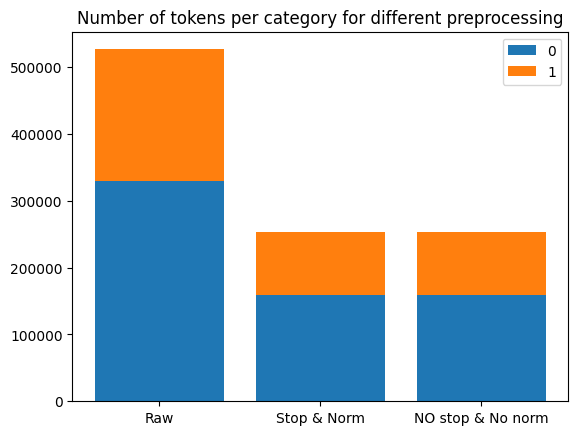

In [37]:
df2 = df1
df2["nbr_tok"] = df2["nlp"].apply(lambda x : len(x))
raw_tok = df2.groupby("label")["nbr_tok"].sum()

df2["nbr_tok_nstop"] = df2["norm"].apply(lambda x : sum(len(s) for s in x))
nstop = df2.groupby("label")["nbr_tok_nstop"].sum()

df2["nbr_tok_stop_norm"] = df2["norm"].apply(lambda x : sum(len(s) for s in x))
stop_norm = df2.groupby("label")["nbr_tok_stop_norm"].sum()

treat = ["Raw", "Stop & Norm", "NO stop & No norm"]


weight_counts = {
    "0": [raw_tok[0], stop_norm[0],nstop[0]],
    "1": [raw_tok[1], stop_norm[1],nstop[1]]
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(treat, weight_count, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of tokens per category for different preprocessing")
ax.legend(loc="upper right")

plt.show()

### Most common tokens by category

In [124]:
def merge_counters(counter):
    """ Merge a nested lists of counters into one Counter object"""
    cc = Counter()
    for c in sum(counter, []):
        cc+=c
    return cc

In [96]:
# Token occurence per category (without stops)
mathematicians = merge_counters(df1[df1["label"]==MATH_LABEL]["counter"])
painters = merge_counters(df1[df1["label"]==PAINT_LABEL]["counter"])

In [97]:
# Token occurence per category (with stops)
mathematicians_wstop =  merge_counters(df1[df1["label"]==MATH_LABEL]["counter_w_stops"])
painters_wstop =  merge_counters(df1[df1["label"]==PAINT_LABEL]["counter_w_stops"])

In [98]:
print("Most common tokens for mathematician category :", mathematicians.most_common(10))
print("Most common tokens for painter category :", painters.most_common(10))

Most common tokens for mathematician category : [('university', 1769), ('mathematics', 1416), ('mathematical', 831), ('theory', 722), ('professor', 547), ('work', 527), ('society', 489), ('american', 460), ('de', 460), ('mathematician', 450)]
Most common tokens for painter category : [('art', 1322), ('painting', 537), ('work', 499), ('paintings', 485), ('works', 482), ('museum', 439), ('artists', 411), ('new', 394), ('painter', 345), ('gallery', 314)]


<BarContainer object of 10 artists>

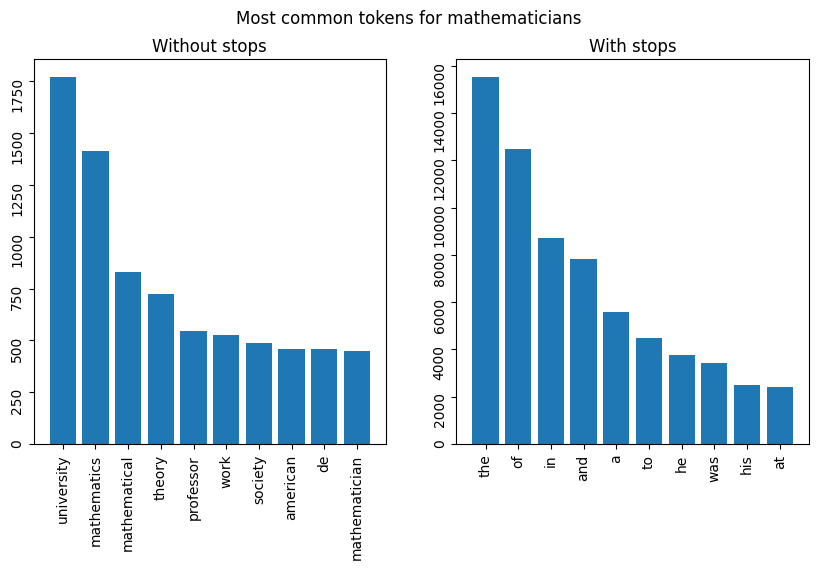

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens for mathematicians')
ax1.bar(*zip(*mathematicians.most_common(10)))
ax1.set_title("Without stops")
ax2.set_title("With stops")
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*mathematicians_wstop.most_common(10)))

<BarContainer object of 10 artists>

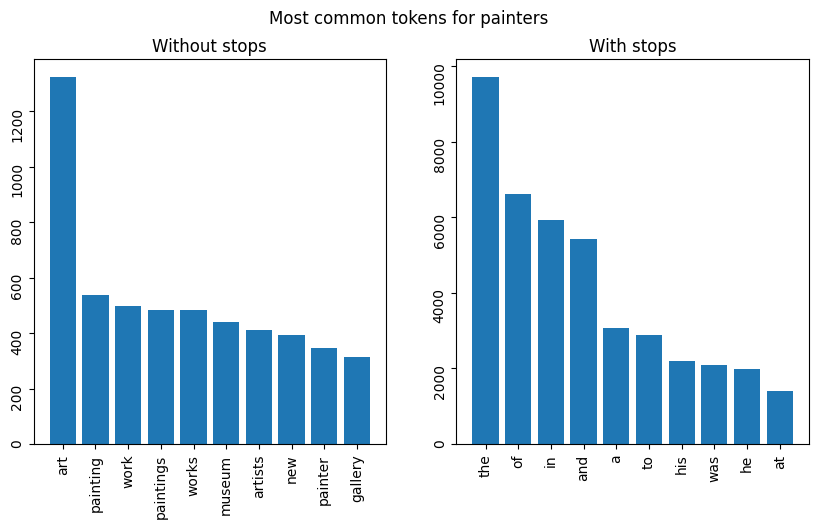

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens for painters')
ax1.bar(*zip(*painters.most_common(10)))
ax1.set_title("Without stops")
ax2.set_title("With stops")
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*painters_wstop.most_common(10)))

### Vocabulary

#### 50 Most common words 

In [102]:
print("Most common 50 words (mathematicians) :")
print("With stopwords :")
print(mathematicians_wstop.most_common(50))
print("Without stopwords :")
print(mathematicians.most_common(50))

Most common 50 words (mathematicians) :
With stopwords :
[('the', 15514), ('of', 12477), ('in', 8737), ('and', 7825), ('a', 5603), ('to', 4477), ('he', 3759), ('was', 3440), ('his', 2513), ('at', 2395), ('on', 2159), ('for', 2145), ('as', 1881), ('s', 1784), ('university', 1769), ('is', 1764), ('with', 1587), ('from', 1543), ('by', 1472), ('that', 1426), ('mathematics', 1416), ('an', 1239), ('mathematical', 831), ('which', 728), ('theory', 722), ('this', 656), ('it', 655), ('also', 628), ('she', 570), ('professor', 547), ('had', 537), ('first', 534), ('work', 527), ('society', 489), ('one', 485), ('her', 469), ('american', 460), ('de', 460), ('be', 454), ('mathematician', 450), ('science', 444), ('new', 443), ('after', 432), ('research', 432), ('has', 429), ('are', 429), ('who', 423), ('not', 421), ('isbn', 412), ('were', 399)]
Without stopwords :
[('university', 1769), ('mathematics', 1416), ('mathematical', 831), ('theory', 722), ('professor', 547), ('work', 527), ('society', 489), (

In [103]:
print("Most common 50 words (painters) :")
print("With stopwords :")
print(painters_wstop.most_common(50))
print("Without stopwords :")
print(painters.most_common(50))

Most common 50 words (painters) :
With stopwords :
[('the', 9698), ('of', 6617), ('in', 5938), ('and', 5412), ('a', 3081), ('to', 2889), ('his', 2191), ('was', 2090), ('he', 1993), ('at', 1391), ('as', 1332), ('art', 1322), ('s', 1190), ('with', 1114), ('by', 1096), ('for', 1072), ('on', 926), ('from', 881), ('that', 736), ('an', 697), ('is', 674), ('were', 609), ('her', 579), ('painting', 537), ('work', 499), ('also', 499), ('paintings', 485), ('works', 482), ('which', 468), ('she', 461), ('museum', 439), ('had', 426), ('artists', 411), ('new', 394), ('this', 382), ('it', 371), ('or', 352), ('painter', 345), ('are', 341), ('who', 333), ('after', 326), ('gallery', 314), ('artist', 312), ('their', 304), ('first', 297), ('school', 290), ('arts', 288), ('one', 288), ('but', 276), ('where', 275)]
Without stopwords :
[('art', 1322), ('painting', 537), ('work', 499), ('paintings', 485), ('works', 482), ('museum', 439), ('artists', 411), ('new', 394), ('painter', 345), ('gallery', 314), ('art

In [104]:
math_norm_nostop_txt = " ".join(sum(df1[df1["label"]==MATH_LABEL]["norm"].apply(lambda x : sum(x, [])), []))
math_norm_wstop_text = " ".join(sum(df1[df1["label"]==MATH_LABEL]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

In [105]:
paint_norm_nostop_txt = " ".join(sum(df1[df1["label"]==PAINT_LABEL]["norm"].apply(lambda x : sum(x, [])), []))
paint_norm_wstop_text = " ".join(sum(df1[df1["label"]==PAINT_LABEL]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

#### Wordcloud

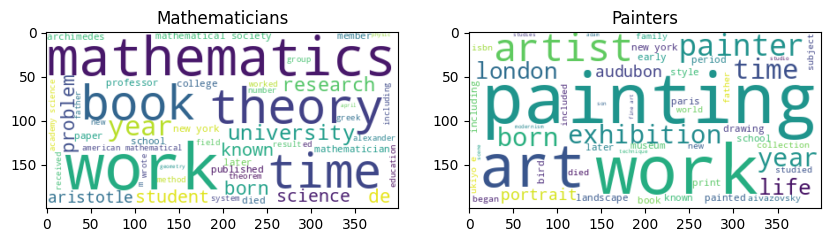

In [106]:
wc1 = WordCloud(background_color = 'white', max_words = 50).generate(math_norm_nostop_txt)
wc2 = WordCloud(background_color = 'white', max_words = 50).generate(paint_norm_nostop_txt)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(wc1, interpolation="bilinear")
ax1.title.set_text('Mathematicians')
ax2.imshow(wc2, interpolation="bilinear")
ax2.title.set_text('Painters')

### Bonus

### Most common postags/NE per category

In [107]:
# Most common verb
def pos_tag(row, ignore=True):
    pos_count = []
    for sent in row.sents:
        c = Counter(token.pos_ for token in sent if (not ignore and not token.pos_ in ("PROPN","PUNCT")) or ignore)
        pos_count.append(c)
    return sum(tuple(pos_count), Counter())

def named_entity(row):
    c = Counter(ne.label_ for ne in row.ents)
    return c

def ne_per_token(row):
    c = Counter((ne.text, ne.label_) for ne in row.ents)
    return c

In [108]:
df1["pos_tags"] = df1["nlp"].apply(pos_tag)
df1["ne"] = df1["nlp"].apply(named_entity)

In [109]:
df1["ne_token"] = df1["nlp"].apply(ne_per_token)

In [110]:
math_pos = sum(df1[df1["label"]==MATH_LABEL]["pos_tags"], Counter())
paint_pos = sum(df1[df1["label"]==PAINT_LABEL]["pos_tags"], Counter())

<BarContainer object of 10 artists>

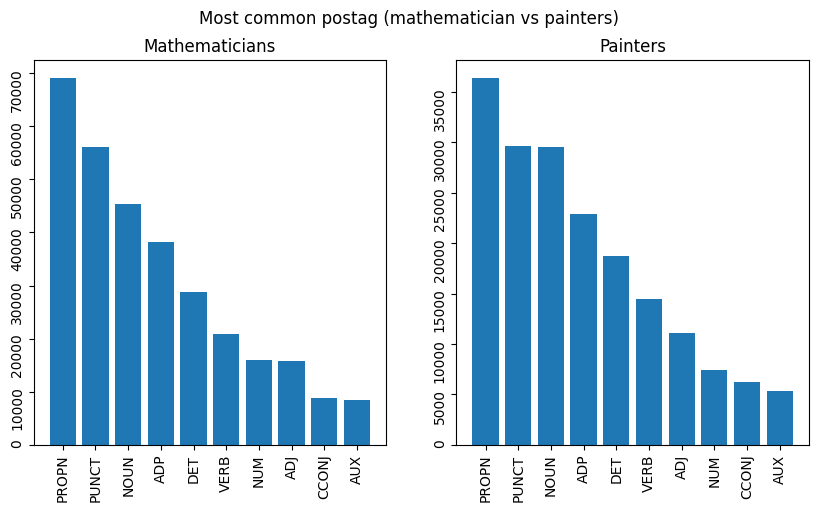

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common postag (mathematician vs painters)')
ax1.bar(*zip(*math_pos.most_common(10)))
ax1.tick_params(rotation=90)
ax1.title.set_text("Mathematicians")
ax2.title.set_text("Painters")
ax2.tick_params(rotation=90)
ax2.bar(*zip(*paint_pos.most_common(10)))

In [112]:
math_ne = sum(df1[df1["label"]==MATH_LABEL]["ne"], Counter())
paint_ne = sum(df1[df1["label"]==PAINT_LABEL]["ne"], Counter())

<BarContainer object of 10 artists>

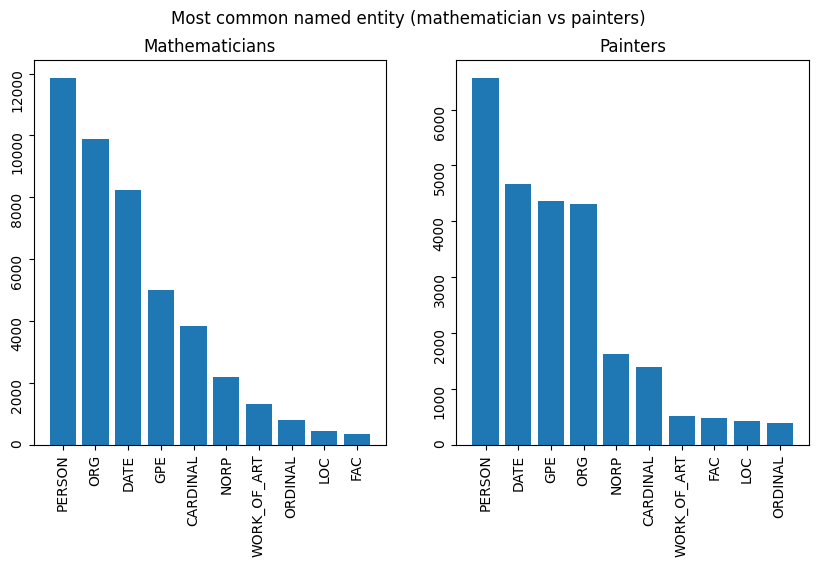

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common named entity (mathematician vs painters)')
ax1.bar(*zip(*math_ne.most_common(10)))
ax1.title.set_text("Mathematicians")
ax2.title.set_text("Painters")
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*paint_ne.most_common(10)))

In [114]:
math_ne_token = sum(df1[df1["label"]==MATH_LABEL]["ne_token"], Counter())
paint_ne_token = sum(df1[df1["label"]==PAINT_LABEL]["ne_token"], Counter())

<BarContainer object of 10 artists>

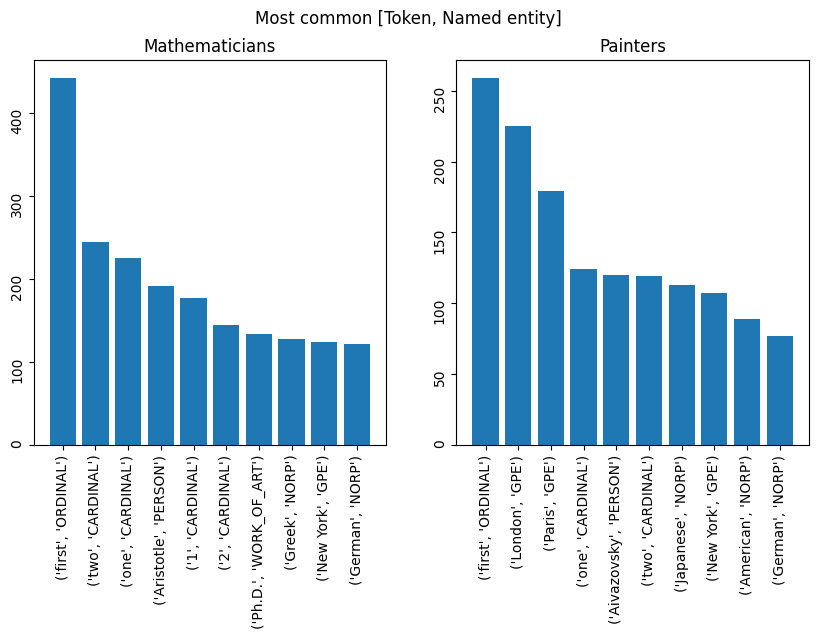

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common [Token, Named entity]')
ax1.bar(*zip(*[(str(ent[0]), ent[1]) for ent in math_ne_token.most_common(10)]))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax1.title.set_text("Mathematicians")
ax2.title.set_text("Painters")
ax2.bar(*zip(*[(str(ent[0]), ent[1]) for ent in paint_ne_token.most_common(10)]))